In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import re
import matplotlib.pyplot as plt

from random import shuffle
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from glob import glob
from torchvision import transforms

In [2]:
data_path = "D:\\car_logo"

In [25]:
def get_images_paths(path):
    """Reads all images in 'path'. Returns (img_paths, img_classes), classes"""
    extensions = ('*.jpg', '*.png', '*.jpeg')  # definw allowed extensions
    classes = {}  # define dict to contain 'class-label' format 
    img_paths, img_classes = [], []
    # get list of images for each extension
    for ext in extensions:
        img_paths.extend(glob(os.path.join(path, ext)))
    
    shuffle(img_paths)
    
    # set labels for each image
    for img_pth in img_paths:
        img_name = img_pth.split('\\')[-1]
        class_name = re.match(r'\D*', img_name.lower().replace(' ', '')).group()  # find words before any digits
        # if it is new class
        if class_name not in classes.keys():
            classes[class_name] = float(len(classes))  # add this class and label
        
        img_classes.append(classes[class_name])
    print(f'Found {len(img_paths)} images with {len(set(img_classes))} classes')
    return (img_paths, img_classes), classes

In [26]:
data, classes = get_images_paths(data_path)

Found 20778 images with 40 classes


In [32]:
# some data examples
list(zip(data[0][:15], data[1][:15]))

[('D:\\car_logo\\Fiat0858_small.jpg', 0.0),
 ('D:\\car_logo\\Saab3543_small.jpg', 1.0),
 ('D:\\car_logo\\Maserati13251_small.jpg', 2.0),
 ('D:\\car_logo\\Citroen14820_small.jpg', 3.0),
 ('D:\\car_logo\\Seat7567_small.jpg', 4.0),
 ('D:\\car_logo\\Dacia16463_small.jpg', 5.0),
 ('D:\\car_logo\\Fiat1073_small.jpg', 0.0),
 ('D:\\car_logo\\Tesla12188_small.jpg', 6.0),
 ('D:\\car_logo\\Jaguar14008_small.jpg', 7.0),
 ('D:\\car_logo\\Land Rover10289_small.jpg', 8.0),
 ('D:\\car_logo\\Lancia7908_small.jpg', 9.0),
 ('D:\\car_logo\\Honda1803_small.jpg', 10.0),
 ('D:\\car_logo\\Audi18169_small.jpg', 11.0),
 ('D:\\car_logo\\Tesla12023_small.jpg', 6.0),
 ('D:\\car_logo\\Porsche4955_small.jpg', 12.0)]

In [28]:
# classes

### Create pytorch iterable Dataset

In [33]:
class ImageDataset(Dataset):
    
    """Create pytorch iterable Dataset to generate images with X paths
    params:
        X[list] - list of paths for images
        Y[list] - list of labels for X
        img_size (int) - size of output images. Default 156
        transform_compose (torchvision.transforms.Compose) - transforms for output images. 
            Default: transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor(),])
    """
    def __init__(self, X, Y, img_size=50, transform_compose=None):
        self.files = X
        self.classes = Y
        self.size = img_size
        self.transforms = transforms.Compose([transforms.Resize((img_size, img_size)), 
                                              transforms.ToTensor(),]) if transform_compose is None else transform_compose  
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, key):
        # get image by path with index=key
        pillow_img = Image.open(self.files[key])
        # apply transforms to image
        x = self.transforms(pillow_img)
        y = self.classes[key]
        return x, y

In [74]:
img_size = 50
train_transforms = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.RandomAffine((-10, 10)),  
                                       transforms.RandomHorizontalFlip(), transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])  # transforms.RandomRotation((-10, 10), expand=False),
valid_transforms = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [37]:
train_size = int(len(data[0]) * 0.75)
print('Train size = ', train_size)

Train size =  15583


In [38]:
# split data - train and validation dataset
train_x, train_y = data[0][:train_size], data[1][:train_size]
valid_x, valid_y = data[0][train_size:], data[1][train_size:]

### Define pytorch DataLoaders to train model

In [75]:
# define train and validation Dataset
train_ds = ImageDataset(train_x, train_y, transform_compose=train_transforms)
valid_ds = ImageDataset(valid_x, valid_y, transform_compose=valid_transforms)

# define DataLoaders
train_dl = DataLoader(train_ds, batch_size=32, pin_memory=False)
valid_dl = DataLoader(valid_ds, batch_size=1, pin_memory=False)

## Create model

In [111]:
class CNN_Net(nn.Module):
    
    def __init__(self, input_channels=3, output_size=1):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2)
        
        self.fc1 = nn.Linear(128, 82)  # c4 shapes
        self.fc2 = nn.Linear(82, 64)
        self.out = nn.Linear(64, output_size)
        
        self.flatten_size = None
    
    def forward(self, x):
        c1 = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        c2 = F.max_pool2d(F.relu(self.conv2(c1)), (2, 2))
        c3 = F.max_pool2d(F.relu(self.conv3(c2)), (2, 2))
        c4 = F.max_pool2d(F.relu(self.conv4(c3)), (2, 2))
        
        if self.flatten_size is None:
            self.flatten_size = c4.shape[1] * c4.shape[2] * c4.shape[3]
            
        c4 = c4.view(-1, self.flatten_size)
        f1 = F.relu(self.fc1(c4))
        f2 = F.relu(self.fc2(f1))
        out = self.out(f2)
        return out

In [137]:
model = CNN_Net(output_size=len(classes))
model = model.cuda()

In [138]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()

## Train model

In [132]:
def accuracy(pred_tensor, target):
    pred_classes = torch.argmax(pred_tensor, dim=1)
    equal_classes = (pred_classes == target).float()
    return torch.mean(equal_classes)

In [139]:
def train(model, epochs, optimizer, loss_func, train_loader, valid_loader=None, train_frac=1.):
    # create history for each epoch list for metrics
    train_history = [[], []]
    valid_history = [[], []]
    for ep in range(epochs):
        # history for current epoch
        ep_train_loss, ep_train_acc = [], []
        for i, (xb, yb) in enumerate(train_loader):
            optimizer.zero_grad()
            # pass to gpu
            yb = yb.long().cuda()
            # get predictions
            preds = model(xb.cuda())
            # calculate loss
            loss = loss_func(preds, yb)
            # backpropagation
            loss.backward()
            optimizer.step()
            
            # calculate metrics for batch
            acc = accuracy(F.softmax(preds), yb).item()
            ep_train_acc.append(acc)
            ep_train_loss.append(loss.item())
            
            if i % 200 == 0:
                print(f'Process {(i/(len(train_loader)*train_frac)):.3}%', "Loss =", round(loss.item(), 4))
                
            if i / len(train_loader) >= train_frac:
                break
            
        # mean accuracy and loss for current epoch
        train_history[0].append(np.array(ep_train_acc).mean())
        train_history[1].append(np.array(ep_train_loss).mean())
        
        # get loss and accuracy for validation data
        if valid_loader is not None:
            eval_acc, eval_loss = [], []
            for xb, yb in valid_loader:
                yb = yb.long().cuda()
                with torch.no_grad():
                    preds = model(xb.cuda())
                
                eval_loss.append(loss_func(preds, yb).item())
                eval_acc.append(accuracy(preds, yb).item())
            # mean accuracy and loss for current epoch with validation data
            valid_history[0].append(np.array(eval_acc).mean())
            valid_history[1].append(np.array(eval_loss).mean())
        
        print(f'Epoch {ep}. acc:', round(np.array(ep_train_acc).mean(), 5), 'loss:', round(np.array(ep_train_loss).mean(), 5))
    
    return train_history, valid_history

In [140]:
train_hist, valid_hist = train(model, epochs=40, optimizer=optimizer, loss_func=loss_function, train_loader=train_dl, valid_loader=valid_dl) # valid_dl

<ipython-input-139-2d60a02e26f4>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  acc = accuracy(F.softmax(preds), yb).item()


Process 0.0% Loss = 3.691
Process 0.411% Loss = 3.5507
Process 0.821% Loss = 3.3768
Epoch 0. acc: 0.06392 loss: 3.52506
Process 0.0% Loss = 3.5718
Process 0.411% Loss = 2.8484
Process 0.821% Loss = 2.8575
Epoch 1. acc: 0.17539 loss: 3.05997
Process 0.0% Loss = 2.771
Process 0.411% Loss = 2.3492
Process 0.821% Loss = 2.1913
Epoch 2. acc: 0.32227 loss: 2.53135
Process 0.0% Loss = 2.5363
Process 0.411% Loss = 2.251
Process 0.821% Loss = 1.6636
Epoch 3. acc: 0.42796 loss: 2.18605
Process 0.0% Loss = 2.4227
Process 0.411% Loss = 2.1184
Process 0.821% Loss = 1.4876
Epoch 4. acc: 0.49772 loss: 1.94013
Process 0.0% Loss = 2.5279
Process 0.411% Loss = 1.8555
Process 0.821% Loss = 1.3759
Epoch 5. acc: 0.54469 loss: 1.75408
Process 0.0% Loss = 2.3062
Process 0.411% Loss = 1.8135
Process 0.821% Loss = 1.4033
Epoch 6. acc: 0.57536 loss: 1.63441
Process 0.0% Loss = 2.2974
Process 0.411% Loss = 1.6448
Process 0.821% Loss = 1.4756
Epoch 7. acc: 0.60174 loss: 1.53425
Process 0.0% Loss = 2.0749
Process 

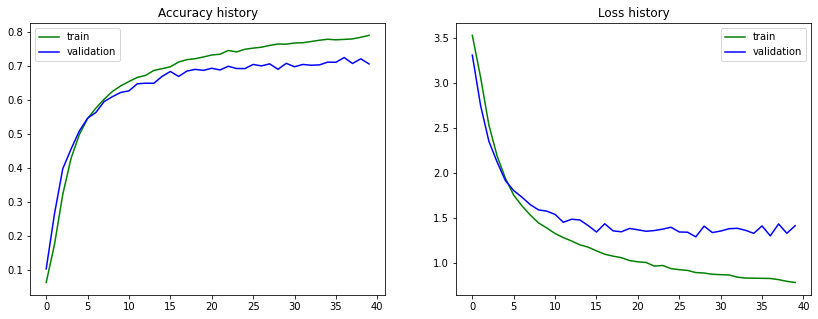

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax[0].plot(train_hist[0], color='green', label='train data', )
ax[0].plot(valid_hist[0], color='blue', label='valid. data')
ax[0].legend()
ax[0].set_title('Accuracy history')

ax[1].plot(train_hist[1], color='green', label='train data')
ax[1].plot(valid_hist[1], color='blue', label='valid. data')
ax[1].legend()
ax[1].set_title('Loss history')

plt.show()

the error on the validation set stopped decreasing after the 15-20 training epoch

<b>Try decrease learning rate and batch size</b>

In [147]:
# Change learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
# Change batch size
train_dl = DataLoader(train_ds, batch_size=16, pin_memory=False)
valid_dl = DataLoader(valid_ds, batch_size=1, pin_memory=False)

In [148]:
train_hist, valid_hist = train(model, epochs=20, optimizer=optimizer, loss_func=loss_function, train_loader=train_dl, valid_loader=valid_dl) # valid_dl

<ipython-input-139-2d60a02e26f4>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  acc = accuracy(F.softmax(preds), yb).item()


Process 0.0% Loss = 1.1732
Process 0.205% Loss = 1.0274
Process 0.411% Loss = 1.1286
Process 0.616% Loss = 0.3552
Process 0.821% Loss = 0.7272
Epoch 0. acc: 0.81794 loss: 0.67287
Process 0.0% Loss = 1.5634
Process 0.205% Loss = 1.0927
Process 0.411% Loss = 1.4162
Process 0.616% Loss = 0.4589
Process 0.821% Loss = 0.781
Epoch 1. acc: 0.82596 loss: 0.63781
Process 0.0% Loss = 1.1421
Process 0.205% Loss = 1.0297
Process 0.411% Loss = 1.2647
Process 0.616% Loss = 0.3088
Process 0.821% Loss = 1.12
Epoch 2. acc: 0.82982 loss: 0.62216
Process 0.0% Loss = 1.2855
Process 0.205% Loss = 1.0065
Process 0.411% Loss = 1.1996
Process 0.616% Loss = 0.227
Process 0.821% Loss = 0.5651
Epoch 3. acc: 0.8381 loss: 0.60141
Process 0.0% Loss = 1.3689
Process 0.205% Loss = 0.8891
Process 0.411% Loss = 0.9089
Process 0.616% Loss = 0.3044
Process 0.821% Loss = 0.9498
Epoch 4. acc: 0.83393 loss: 0.5944
Process 0.0% Loss = 1.1933
Process 0.205% Loss = 0.9882
Process 0.411% Loss = 0.7915
Process 0.616% Loss = 0.38

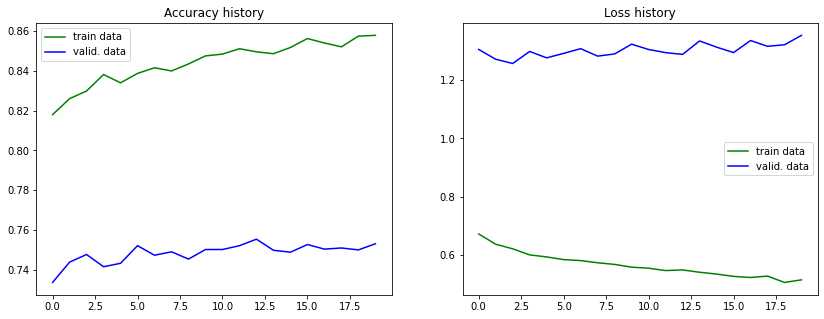

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax[0].plot(train_hist[0], color='green', label='train data', )
ax[0].plot(valid_hist[0], color='blue', label='valid. data')
ax[0].legend()
ax[0].set_title('Accuracy history')

ax[1].plot(train_hist[1], color='green', label='train data')
ax[1].plot(valid_hist[1], color='blue', label='valid. data')
ax[1].legend()
ax[1].set_title('Loss history')

plt.show()

model has a little improvements. Training loss decreases but validation isn't

In [150]:
torch.save(model, 'cnn_model.pt')

## Make some tests

In [153]:
def validate_model(model, data_loader, num_samples=100, cuda_model=True):
    predictions, real_classes = [], []
    # get X and Y from data_loader
    for sample_index, (xb, yb) in enumerate(data_loader):
        with torch.no_grad():
            # pass X to model
            if cuda_model:
                preds = model(xb.cuda())
            else:
                preds = model(xb)
        preds = F.softmax(preds)  # pass results to activate function
        predictions.append(torch.argmax(preds.cpu()).item())  # get value with max probability
        real_classes.append(yb.item())
        if sample_index == num_samples:
            break
            
    predictions = np.array(predictions, dtype=int)
    real_classes = np.array(real_classes, dtype=int)
    print("accuracy is", np.mean((predictions==real_classes).astype(float)) )  # calc. accuracy
    return predictions, real_classes

In [154]:
valid_preds, valid_real = validate_model(model, valid_dl, num_samples=500)

<ipython-input-153-d7fba7efd817>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = F.softmax(preds)  # pass results to activate function


accuracy is 0.7524950099800399


In [161]:
reversed_classes = dict((int(val), key) for key, val in classes.items())
# reversed_classes

In [164]:
for i in range(20):
    sample_index = np.random.randint(0, 500)
    print("predicted", '{:>15}'.format(reversed_classes[valid_preds[sample_index]].upper()),
          "real", reversed_classes[valid_real[sample_index]].upper())

predicted           LEXUS real PEUGEOT
predicted          TOYOTA real TOYOTA
predicted         PEUGEOT real PEUGEOT
predicted          TOYOTA real TOYOTA
predicted      VOLKSWAGEN real BMW
predicted         PORSCHE real PORSCHE
predicted           TESLA real PEUGEOT
predicted       LANDROVER real LANDROVER
predicted          TOYOTA real TOYOTA
predicted            LADA real LADA
predicted            OPEL real OPEL
predicted          SUBARU real KIA
predicted         FERRARI real FERRARI
predicted       ALFAROMEO real ALFAROMEO
predicted          NISSAN real NISSAN
predicted          NISSAN real NISSAN
predicted       LANDROVER real LANDROVER
predicted          TOYOTA real TOYOTA
predicted         HYUNDAI real HYUNDAI
predicted           LEXUS real LEXUS
